# Twitter Sentiment Analysis

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Reshape
import keras

# nltk
import nltk
import ssl
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

2022-12-13 19:28:29.101603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

### Settings

In [3]:
# DATASET
COLUMNS_DATASET = ["target", "ids", "date", "flag", "user", "text"]
DATASETENCODING = "ISO-8859-1"
TRAINSIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 

WINDOW_W2V = 10
SIZE_W2V = 500
MIN_COUNT_W2V = 15
EPOCH_W2V = 50



# EXPORT
KERASMODEL = "model.h5"
WORD2VECMODEL = "model.w2v"
TOKENIZERMODEL = "tokenizer.pkl"
ENCODERMODEL = "encoder.pkl"

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.5, 0.7)


# KERAS
EPOCHS = 8
LENGTH_SEQ = 300
BATCHSIZE = 1024

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [4]:
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding =DATASETENCODING , names=COLUMNS_DATASET)

In [5]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [31]:
df

,target,ids,date,flag,user,text
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww bummer shoulda got david carr third day
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset update facebook texting might cry result...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving mad see
...,...,...,...,...,...,...
1599995,POSITIVE,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,woke school best feeling ever
1599996,POSITIVE,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,thewdb com cool hear old walt interviews
1599997,POSITIVE,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,ready mojo makeover ask details
1599998,POSITIVE,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,happy 38th birthday boo alll time tupac amaru ...


### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [6]:
decodemap = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decodesentiment(label):
    return decodemap[int(label)]

In [7]:
%%time
df['target'] = df['target'].apply(lambda x: decodesentiment(x))

CPU times: user 483 ms, sys: 16.2 ms, total: 499 ms
Wall time: 531 ms


Text(0.5, 1.0, 'Distribuition of dataset labels')

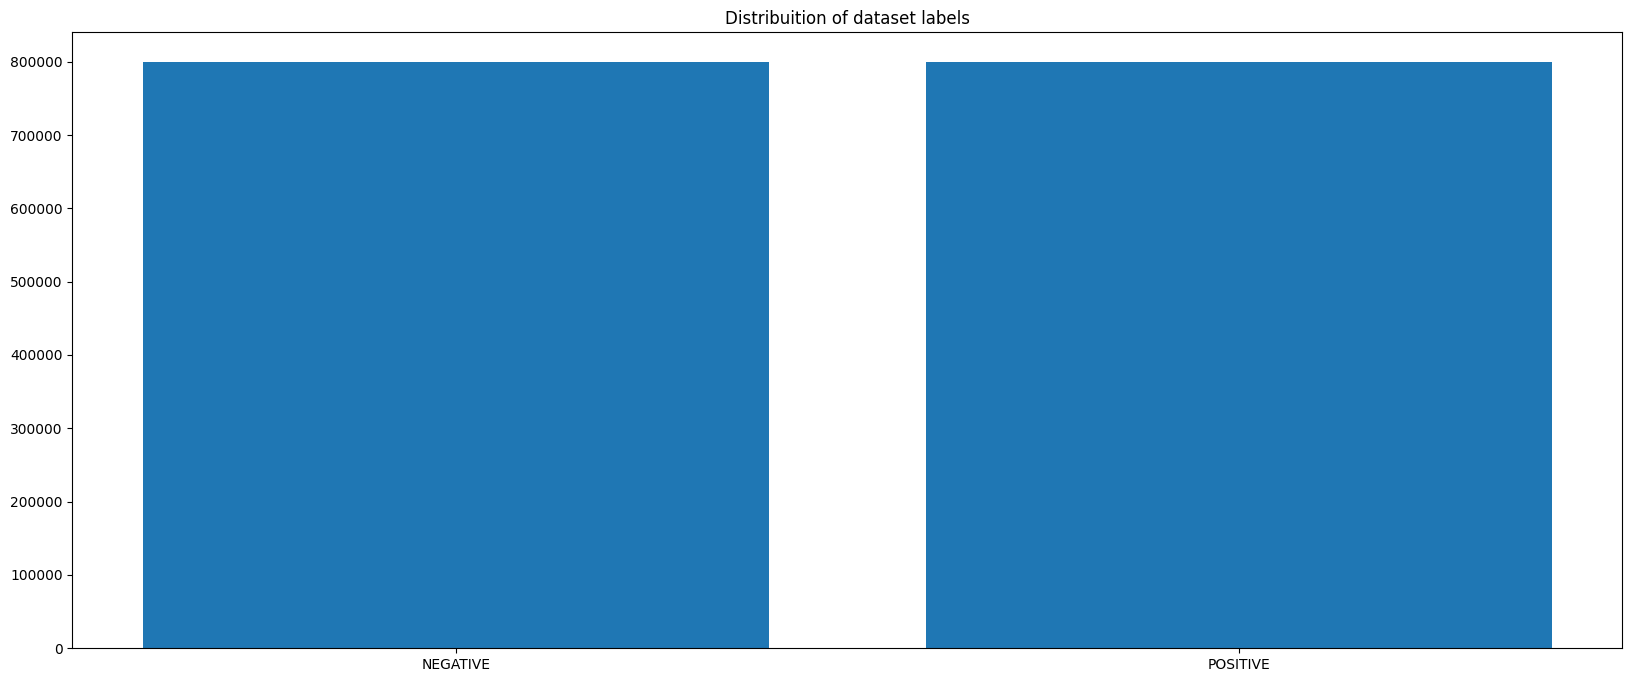

In [8]:
target_count = Counter(df['target'])

plt.figure(figsize=(20,8))
plt.bar(target_count.keys(), target_count.values())
plt.title("Distribuition of dataset labels")

### Pre-Process dataset

In [9]:
stop_words_final = stopwords.words("english")
stemmer_final = SnowballStemmer("english")

In [10]:
def preprocess_dataset(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words_final:
            if stem:
                tokens.append(stemmer_final.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
%%time
df['text'] = df['text'].apply(lambda x: preprocess_dataset(x))

CPU times: user 59.9 s, sys: 277 ms, total: 1min
Wall time: 1min


### Split train and test

In [12]:
traindf, testdf = train_test_split(df, test_size=1-TRAINSIZE, random_state=None)
print("TRAIN size:", len(traindf))
print("TEST size:", len(testdf))

TRAIN size: 1280000
TEST size: 320000


### Word2Vec 

In [13]:
%%time
documents_final = [_text.split() for _text in traindf.text] 

CPU times: user 3.61 s, sys: 241 ms, total: 3.85 s
Wall time: 3.88 s


In [14]:
W2VMODEL_final = gensim.models.word2vec.Word2Vec(vector_size=SIZE_W2V,
                                            window=WINDOW_W2V, 
                                            min_count=MIN_COUNT_W2V, 
                                            workers=8)

2022-12-13 19:30:10,528 : INFO : Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=500, alpha=0.025>', 'datetime': '2022-12-13T19:30:10.528656', 'gensim': '4.2.0', 'python': '3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-12.6.1-x86_64-i386-64bit', 'event': 'created'}


In [15]:
W2VMODEL_final.build_vocab(documents_final)

2022-12-13 19:30:10,542 : INFO : collecting all words and their counts
2022-12-13 19:30:10,545 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-12-13 19:30:10,588 : INFO : PROGRESS: at sentence #10000, processed 71940 words, keeping 13917 word types
2022-12-13 19:30:10,630 : INFO : PROGRESS: at sentence #20000, processed 144681 words, keeping 21556 word types
2022-12-13 19:30:10,664 : INFO : PROGRESS: at sentence #30000, processed 216925 words, keeping 27523 word types
2022-12-13 19:30:10,692 : INFO : PROGRESS: at sentence #40000, processed 289003 words, keeping 32887 word types
2022-12-13 19:30:10,718 : INFO : PROGRESS: at sentence #50000, processed 361306 words, keeping 37585 word types
2022-12-13 19:30:10,745 : INFO : PROGRESS: at sentence #60000, processed 433345 words, keeping 42113 word types
2022-12-13 19:30:10,780 : INFO : PROGRESS: at sentence #70000, processed 504968 words, keeping 46345 word types
2022-12-13 19:30:10,814 : INFO : PROGRESS: at s

2022-12-13 19:30:12,847 : INFO : PROGRESS: at sentence #720000, processed 5191293 words, keeping 201043 word types
2022-12-13 19:30:12,886 : INFO : PROGRESS: at sentence #730000, processed 5264053 words, keeping 202854 word types
2022-12-13 19:30:12,946 : INFO : PROGRESS: at sentence #740000, processed 5335976 words, keeping 204613 word types
2022-12-13 19:30:12,997 : INFO : PROGRESS: at sentence #750000, processed 5408457 words, keeping 206322 word types
2022-12-13 19:30:13,026 : INFO : PROGRESS: at sentence #760000, processed 5480341 words, keeping 208152 word types
2022-12-13 19:30:13,061 : INFO : PROGRESS: at sentence #770000, processed 5552715 words, keeping 209914 word types
2022-12-13 19:30:13,101 : INFO : PROGRESS: at sentence #780000, processed 5624059 words, keeping 211618 word types
2022-12-13 19:30:13,127 : INFO : PROGRESS: at sentence #790000, processed 5695945 words, keeping 213320 word types
2022-12-13 19:30:13,165 : INFO : PROGRESS: at sentence #800000, processed 576827

In [16]:
#words = w2v_model.wv.vocab.keys()
words_final = list(W2VMODEL_final.wv.key_to_index.keys())
vocab_size_final = len(words_final)
print("Vocab size", vocab_size_final)

Vocab size 23505


In [17]:
%%time
W2VMODEL_final.train(documents_final, total_examples=len(documents_final), epochs=EPOCH_W2V)

2022-12-13 19:30:15,787 : INFO : Word2Vec lifecycle event {'msg': 'training model with 8 workers on 23505 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2022-12-13T19:30:15.787785', 'gensim': '4.2.0', 'python': '3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-12.6.1-x86_64-i386-64bit', 'event': 'train'}
2022-12-13 19:30:16,815 : INFO : EPOCH 0 - PROGRESS: at 6.50% examples, 524708 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:30:17,822 : INFO : EPOCH 0 - PROGRESS: at 13.88% examples, 559648 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:30:18,864 : INFO : EPOCH 0 - PROGRESS: at 21.24% examples, 565107 words/s, in_qsize 14, out_qsize 1
2022-12-13 19:30:19,870 : INFO : EPOCH 0 - PROGRESS: at 28.17% examples, 563870 words/s, in_qsize 14, out_qsize 1
2022-12-13 19:30:20,886 : INFO : EPOCH 0 - PROGRESS: at 35.76% examples, 572538 words/s, in_qsize 16, out_qsize 1

2022-12-13 19:31:24,481 : INFO : EPOCH 4 - PROGRESS: at 94.46% examples, 582374 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:31:25,199 : INFO : EPOCH 4: training on 9226989 raw words (8134601 effective words) took 13.9s, 584677 effective words/s
2022-12-13 19:31:26,214 : INFO : EPOCH 5 - PROGRESS: at 6.60% examples, 536331 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:31:27,244 : INFO : EPOCH 5 - PROGRESS: at 13.44% examples, 537239 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:31:28,256 : INFO : EPOCH 5 - PROGRESS: at 19.84% examples, 529524 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:31:29,259 : INFO : EPOCH 5 - PROGRESS: at 26.11% examples, 524729 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:31:30,290 : INFO : EPOCH 5 - PROGRESS: at 33.04% examples, 529188 words/s, in_qsize 15, out_qsize 3
2022-12-13 19:31:31,295 : INFO : EPOCH 5 - PROGRESS: at 40.40% examples, 540265 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:31:32,298 : INFO : EPOCH 5 - PROGRESS: at 47.55% examp

2022-12-13 19:32:34,359 : INFO : EPOCH 9 - PROGRESS: at 95.65% examples, 590487 words/s, in_qsize 15, out_qsize 1
2022-12-13 19:32:34,896 : INFO : EPOCH 9: training on 9226989 raw words (8135736 effective words) took 13.7s, 593112 effective words/s
2022-12-13 19:32:35,915 : INFO : EPOCH 10 - PROGRESS: at 7.04% examples, 568358 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:32:36,968 : INFO : EPOCH 10 - PROGRESS: at 14.64% examples, 577279 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:32:38,009 : INFO : EPOCH 10 - PROGRESS: at 22.21% examples, 582443 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:32:39,015 : INFO : EPOCH 10 - PROGRESS: at 29.79% examples, 589961 words/s, in_qsize 16, out_qsize 0
2022-12-13 19:32:40,024 : INFO : EPOCH 10 - PROGRESS: at 37.16% examples, 590727 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:32:41,036 : INFO : EPOCH 10 - PROGRESS: at 44.62% examples, 592342 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:32:42,048 : INFO : EPOCH 10 - PROGRESS: at 51.99

2022-12-13 19:33:45,108 : INFO : EPOCH 14 - PROGRESS: at 64.65% examples, 573722 words/s, in_qsize 16, out_qsize 2
2022-12-13 19:33:46,110 : INFO : EPOCH 14 - PROGRESS: at 72.00% examples, 576136 words/s, in_qsize 16, out_qsize 1
2022-12-13 19:33:47,117 : INFO : EPOCH 14 - PROGRESS: at 79.82% examples, 581021 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:33:48,125 : INFO : EPOCH 14 - PROGRESS: at 87.30% examples, 582829 words/s, in_qsize 16, out_qsize 1
2022-12-13 19:33:49,135 : INFO : EPOCH 14 - PROGRESS: at 94.79% examples, 584296 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:33:49,754 : INFO : EPOCH 14: training on 9226989 raw words (8135584 effective words) took 13.8s, 588795 effective words/s
2022-12-13 19:33:50,772 : INFO : EPOCH 15 - PROGRESS: at 7.25% examples, 587477 words/s, in_qsize 16, out_qsize 0
2022-12-13 19:33:51,813 : INFO : EPOCH 15 - PROGRESS: at 13.44% examples, 533934 words/s, in_qsize 14, out_qsize 1
2022-12-13 19:33:52,861 : INFO : EPOCH 15 - PROGRESS: at 20.

2022-12-13 19:34:54,850 : INFO : EPOCH 19 - PROGRESS: at 59.02% examples, 588017 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:34:55,855 : INFO : EPOCH 19 - PROGRESS: at 66.49% examples, 589919 words/s, in_qsize 14, out_qsize 1
2022-12-13 19:34:56,859 : INFO : EPOCH 19 - PROGRESS: at 73.96% examples, 591459 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:34:57,875 : INFO : EPOCH 19 - PROGRESS: at 81.34% examples, 591327 words/s, in_qsize 16, out_qsize 1
2022-12-13 19:34:58,878 : INFO : EPOCH 19 - PROGRESS: at 89.04% examples, 594068 words/s, in_qsize 15, out_qsize 1
2022-12-13 19:34:59,881 : INFO : EPOCH 19 - PROGRESS: at 96.42% examples, 594329 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:35:00,299 : INFO : EPOCH 19: training on 9226989 raw words (8135679 effective words) took 13.6s, 597467 effective words/s
2022-12-13 19:35:01,313 : INFO : EPOCH 20 - PROGRESS: at 6.72% examples, 545498 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:35:02,315 : INFO : EPOCH 20 - PROGRESS: at 13.

2022-12-13 19:36:04,219 : INFO : EPOCH 24 - PROGRESS: at 57.73% examples, 514697 words/s, in_qsize 14, out_qsize 1
2022-12-13 19:36:05,285 : INFO : EPOCH 24 - PROGRESS: at 62.82% examples, 501440 words/s, in_qsize 16, out_qsize 0
2022-12-13 19:36:06,317 : INFO : EPOCH 24 - PROGRESS: at 68.10% examples, 493840 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:36:07,322 : INFO : EPOCH 24 - PROGRESS: at 73.52% examples, 489280 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:36:08,333 : INFO : EPOCH 24 - PROGRESS: at 79.17% examples, 486534 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:36:09,380 : INFO : EPOCH 24 - PROGRESS: at 84.92% examples, 483595 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:36:10,409 : INFO : EPOCH 24 - PROGRESS: at 91.10% examples, 483892 words/s, in_qsize 15, out_qsize 0
2022-12-13 19:36:11,411 : INFO : EPOCH 24 - PROGRESS: at 96.75% examples, 482278 words/s, in_qsize 16, out_qsize 3
2022-12-13 19:36:11,847 : INFO : EPOCH 24: training on 9226989 raw words (813444

KeyboardInterrupt: 

In [18]:
W2VMODEL_final.wv.most_similar("love")

[('luv', 0.4917762875556946),
 ('loves', 0.44830799102783203),
 ('looove', 0.42896777391433716),
 ('adore', 0.4069608747959137),
 ('loved', 0.3839113116264343),
 ('lovee', 0.38276422023773193),
 ('amazing', 0.3525390923023224),
 ('awesome', 0.3434097170829773),
 ('loove', 0.33321109414100647),
 ('loooove', 0.3300868272781372)]

### Tokenize Text

In [19]:
%%time
tokenizer_finalv = Tokenizer()
tokenizer_finalv.fit_on_texts(traindf.text)

vocab_len = len(tokenizer_finalv.word_index) + 1
print("Total words", vocab_len)

Total words 290549
CPU times: user 21.4 s, sys: 223 ms, total: 21.6 s
Wall time: 22.2 s


In [20]:
%%time
train_x = pad_sequences(tokenizer_finalv.texts_to_sequences(traindf.text), maxlen=LENGTH_SEQ)
test_x = pad_sequences(tokenizer_finalv.texts_to_sequences(testdf.text), maxlen=LENGTH_SEQ)

CPU times: user 27.1 s, sys: 1.46 s, total: 28.6 s
Wall time: 29.6 s


### Label Encoder 

In [21]:
labels = traindf['target'].unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [22]:
label_encoder = LabelEncoder()
label_encoder.fit(traindf.target.tolist())

train_y = label_encoder.transform(traindf.target.tolist())
test_y = label_encoder.transform(testdf.target.tolist())

train_y = train_y.reshape(-1,1)
test_y = test_y.reshape(-1,1)

print("train_y",train_y.shape)
print("test_y",test_y.shape)

train_y (1280000, 1)
test_y (320000, 1)


In [23]:
print("train_x shape", train_x.shape)
print("train_y shape", train_y.shape)
print()
print("test_x shape", test_x.shape)
print("test_y shape", test_y.shape)

train_x shape (1280000, 300)
train_y shape (1280000, 1)

test_x shape (320000, 300)
test_y shape (320000, 1)


In [24]:
x_train=train_x[:10000]
y_train=train_y[:10000]

In [25]:
x_test=test_x[:1000]
y_test=test_y[:1000]

### Embedding layer

In [26]:
embedding_matrix = np.zeros((vocab_len,SIZE_W2V))
for word, i in tokenizer_finalv.word_index.items():
  if word in W2VMODEL_final.wv:
    embedding_matrix[i-1] = W2VMODEL_final.wv[word]
print(embedding_matrix.shape)

(290549, 500)


In [27]:
embedding_layer = Embedding(vocab_len, SIZE_W2V, weights=[embedding_matrix], input_length=LENGTH_SEQ, trainable=True)

### Build Model

In [28]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.1))
model.add(Reshape((20,5,1)))
model.add(Conv2D(256, kernel_size=3, activation='relu', input_shape=(20,5)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(6, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

2022-12-13 19:37:36.547592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 500)          145274500 
                                                                 
 dropout (Dropout)           (None, 300, 500)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               240400    
                                                                 
 reshape (Reshape)           (None, 20, 5, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 18, 3, 256)        2560      
                                                                 
 flatten (Flatten)           (None, 13824)             0         
                                                                 
 dense (Dense)               (None, 10)                1

### Compile model

In [29]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Callbacks

In [30]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0)]
              #EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [90]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=1000,
                    epochs=1,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/15
45/45 [==============================] - 1077s 24s/step - loss: 0.6584 - accuracy: 0.5974 - val_loss: 0.5887 - val_accuracy: 0.6922 - lr: 0.0010
Epoch 2/15
45/45 [==============================] - 1023s 23s/step - loss: 0.5737 - accuracy: 0.6982 - val_loss: 0.5584 - val_accuracy: 0.7232 - lr: 0.0010
Epoch 3/15
45/45 [==============================] - 1013s 23s/step - loss: 0.5199 - accuracy: 0.7447 - val_loss: 0.5356 - val_accuracy: 0.7406 - lr: 0.0010
Epoch 4/15
45/45 [==============================] - 1022s 23s/step - loss: 0.4855 - accuracy: 0.7692 - val_loss: 0.5329 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 5/15
45/45 [==============================] - 1011s 22s/step - loss: 0.4519 - accuracy: 0.7925 - val_loss: 0.5449 - val_accuracy: 0.7492 - lr: 0.0010
Epoch 6/15
45/45 [==============================] - 1013s 23s/step - loss: 0.4270 - accuracy: 0.8076 - val_loss: 0.5459 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 7/15
45/45 [==============================] - 1016s 23s/st

### Evaluate

In [93]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCHSIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

10/10 [==============================] - 26s 2s/step - loss: 0.6238 - accuracy: 0.7406

ACCURACY: 0.7405999898910522
LOSS: 0.6237931847572327
CPU times: user 1min 13s, sys: 15.1 s, total: 1min 28s
Wall time: 26.4 s


### Predict

In [94]:
def sentimentdecoder(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [95]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer_finalv.texts_to_sequences([text]), maxlen=LENGTH_SEQ)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = sentimentdecoder(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [96]:
predict("I love the music")

1/1 [==============================] - 1s 647ms/step


{'label': 'POSITIVE',
 'score': 0.9763351678848267,
 'elapsed_time': 0.7400579452514648}

In [97]:
predict("I am not crazy")

1/1 [==============================] - 0s 69ms/step


{'label': 'POSITIVE',
 'score': 0.8740862011909485,
 'elapsed_time': 0.15700888633728027}

In [98]:
predict("i am not unhappy")

1/1 [==============================] - 0s 61ms/step


{'label': 'NEGATIVE',
 'score': 0.045241184532642365,
 'elapsed_time': 0.15354204177856445}

### Confusion Matrix

In [112]:
%%time
y_predicted_1d = []
y_test_1d = list(testdf.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_predicted_1d = [sentimentdecoder(score, include_neutral=False) for score in scores]

2/2 [==============================] - 112s 5s/step
CPU times: user 1min 8s, sys: 1min 7s, total: 2min 16s
Wall time: 1min 52s


In [113]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

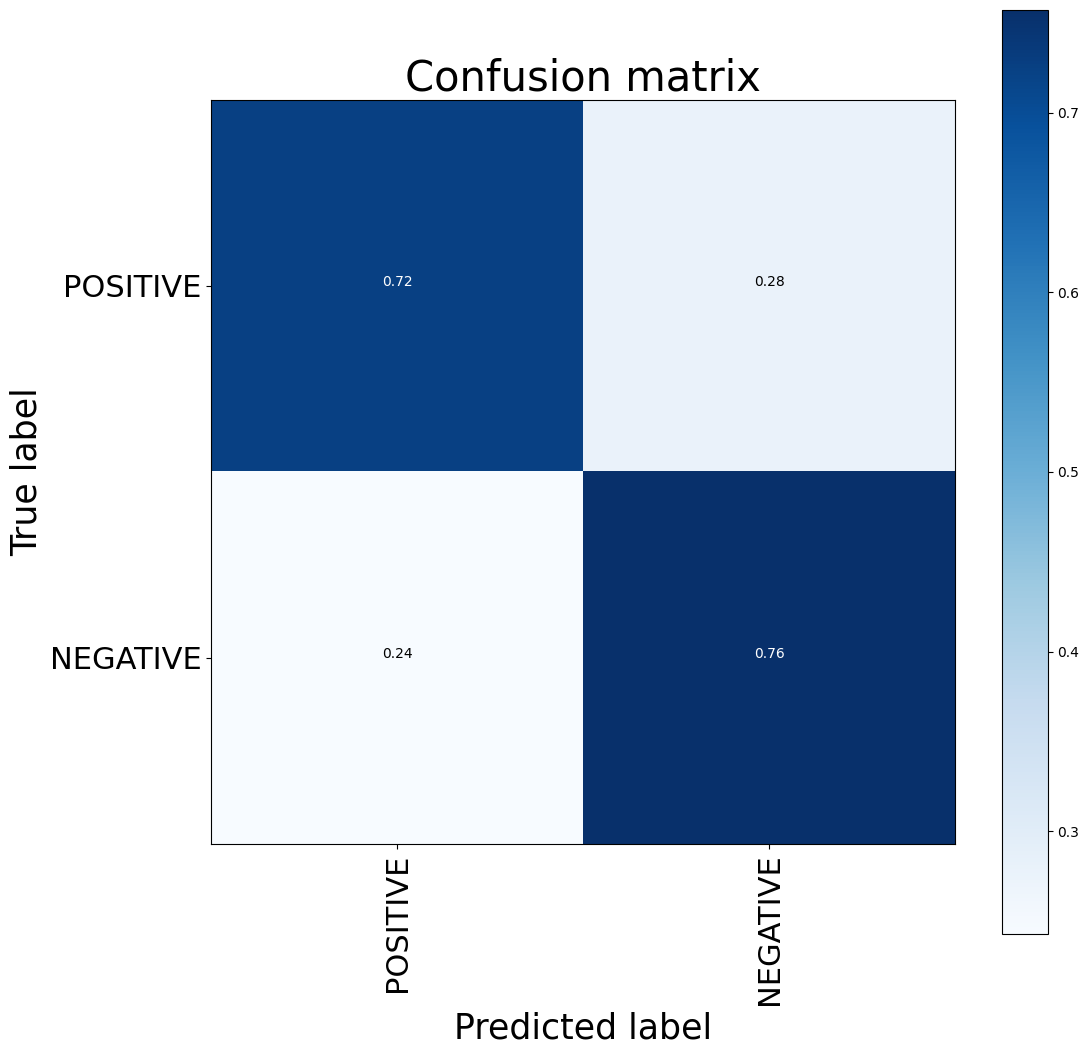

CPU times: user 693 ms, sys: 132 ms, total: 825 ms
Wall time: 831 ms


In [116]:
%%time
cnf_matrix = confusion_matrix(y_test_1d[:10000], y_predicted_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=traindf.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [119]:
print(classification_report(y_test_1d[:10000], y_predicted_1d[:10000]))

              precision    recall  f1-score   support

    NEGATIVE       0.75      0.72      0.74      5034
    POSITIVE       0.73      0.76      0.74      4966

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000



### Accuracy Score

In [122]:
accuracy_score(y_test_1d[:10000], y_predicted_1d[:10000])

0.7406